https://adventofcode.com/2022/day/15

In [1]:
import re
from typing import Iterator, Optional
# from tqdm.notebook import tqdm
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

def read_data(filename:str) -> Iterator[tuple[tuple[int, int], tuple[int, int]]]:
    with open(filename, 'r') as f:
        for line in f.readlines():
            i = tuple(map(int, re.findall('[-\d]+', line)))
            yield (i[0], i[1]), (i[2], i[3])
            
def distance(i: tuple[int, int],
             j: tuple[int, int]) -> int:
    return abs(i[0]-j[0]) + abs(i[1]-j[1])

def distance(i: tuple[int, int],
             j: tuple[int, int]) -> int:
    return int(np.linalg.norm(np.array(i)-np.array(j), ord=1))

def row_excluded_limits(row_y: int,
                        signal: tuple[int, int],
                        distance: int) -> Optional[tuple[int, int]]:
    offset = distance - abs(row_y-signal[1])
    return (signal[0]-offset, signal[0]+offset) if offset >= 0 else None

def row_excluded(row_y: int,
                 signal: tuple[int, int],
                 distance: int,
                 x_lim: Optional[tuple[int, int]]= None) -> set:
    limits = row_excluded_limits(row_y, signal, distance)
    if not limits:
        return set()
    else:
        if x_lim:
            limits = (max(x_lim[0], limits[0]), min(x_lim[1], limits[1]))
        return set(range(limits[0], limits[1]+1)) if limits else set()

def solve_part_1(row: int,
                 filename: str) -> int:
    excluded = set()
    beacons = set()
    for signal, beacon in read_data(filename):
        if beacon[1] == row: beacons.add(beacon[0])
        signal_range = (signal, distance(signal, beacon))
        to_exclude = row_excluded(row, *signal_range)
        excluded.update(to_exclude)
    return len(excluded - beacons)

def square_spacing(s1, d1, s2, d2):
    return abs(s1[0] - s2[0]) - (d1 + d2) + abs(s1[1] - s2[1])

def overlapping_squares(s1, d1, s2, d2) -> bool:
    return square_spacing(s1, d1, s2, d2) <= 0

def line_from_adjacent_squares(s1, d1, s2, d2):
    p1 = s1[0], s1[1]+d1+1
    p2 = s2[0], s2[1]-d2-1
    p3 = s1[0], s1[1]-d1-1
    p4 = s2[0], s2[1]+d2+1
    l1 = line_from_points(p1, p2) 
    l2 = line_from_points(p3, p4) 
    if abs(l1[0]) == 1.0:
        return l1
    else:
        return l2
    
def line_from_points(p1, p2):
    A = np.array([[p1[0], 1],
                  [p2[0], 1]])
    b = np.array([p1[1], p2[1]])
    return np.rint(np.linalg.solve(A, b)).astype(int)

def plot_square(s, d, label=None):
    x_points = (s[0], s[0]+d, s[0], s[0]-d, s[0])
    y_points = (s[1]+d, s[1], s[1]-d, s[1], s[1]+d)
    plt.plot(x_points, y_points, label=label)
    
def line(x, m, c):
    return m*x + c

def solve_crossing_lines(l1, l2):
    A = np.array([[-l1[0], 1],
                  [-l2[0], 1]])
    b = np.array([l1[1], l2[1]])
    return np.rint(np.linalg.solve(A, b)).astype(int)

def solve_part_2(filename: str,
                 lim: int,
                 plotting: bool=False) -> int:
    pairings = ((0,1,2,3),
                (0,2,1,3),
                (0,3,1,2))
    signal_distance_pairs = []
    for signal, beacon in read_data(filename):
        signal_distance_pairs.append((signal, distance(signal, beacon)))

    for four_squares in combinations(signal_distance_pairs, 4):
        for p in pairings:
            i, j, k, l = [four_squares[n] for n in p]
            sep = []
            possible = False
            sep.append(square_spacing(*i, *j))
            sep.append(square_spacing(*k, *l))
            if sep == [2,2]:
                overlaps = []
                overlaps.append(overlapping_squares(*i, *k))
                overlaps.append(overlapping_squares(*i, *l))
                overlaps.append(overlapping_squares(*j, *k))
                overlaps.append(overlapping_squares(*j, *l))
                if np.all(overlaps):
                    l1 = line_from_adjacent_squares(*i, *j)
                    l2 = line_from_adjacent_squares(*k, *l)              
                    if plotting:
                        fig = plt.figure()
                        ax = fig.add_subplot()
                        for n, s in enumerate([i,j,k,l], 1):
                            plot_square(*s)
                        ax.set_aspect('equal')
                        x_range = np.array([0, lim])
                        plt.plot(x_range, line(x_range, *l1), '--')
                        plt.plot(x_range, line(x_range, *l2), '--')

                        ax.set_xlim(0, lim)
                        ax.set_ylim(0, lim)
                        plt.show()
                    break
        else:
            continue
        break
    x, y = solve_crossing_lines(l1, l2)
    if plotting:
        print(f'The beacon is at ({x}, {y})')
    solution = 4000000*x + y
    return solution

In [2]:
filename = "../example_data/day15_example_data.txt"
solve_part_1(row=10, filename=filename)

26

In [3]:
filename = "../data/day15_data.txt"
solve_part_1(row=2000000, filename=filename)

5125700

I came up with this solution after looking at some of the other "smart" solutions on the subreddit.

Algorithm:

- Each sensor + beacon pair defines a square of points that cannot contain the distress beacon.,
- Assume that we are looking for a single point that is bounded by four squares.
     - This means that we want to find a set of four squares where:
         - We have two pairs of squares with a separation of 2.
         - All other combinations of squares have a separation of 0 or overlap (separation is negative).
- Loop over all combinations of 4 squares, until we find a set of 4 squares that fit the criteria above.
- Generate a pair of lines that run *between* each pair of squares.
- Compute the point where these cross.
    
(no Manhattan distances calculated)

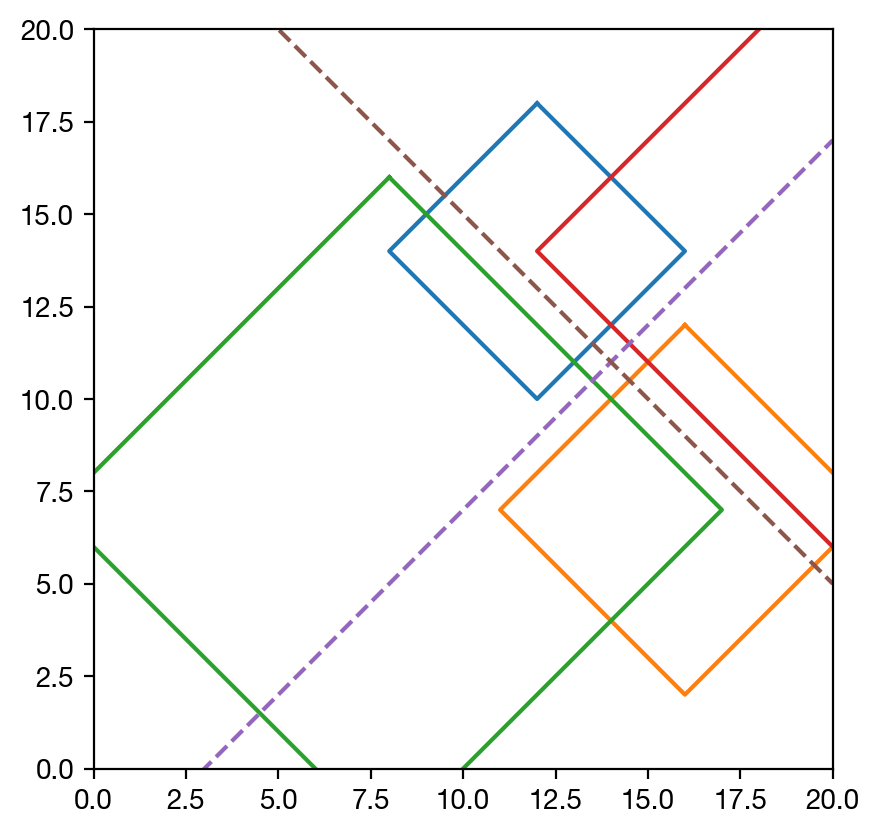

The beacon is at (14, 11)


56000011

In [4]:
filename = "../example_data/day15_example_data.txt"
solve_part_2(filename, lim=20, plotting=True)

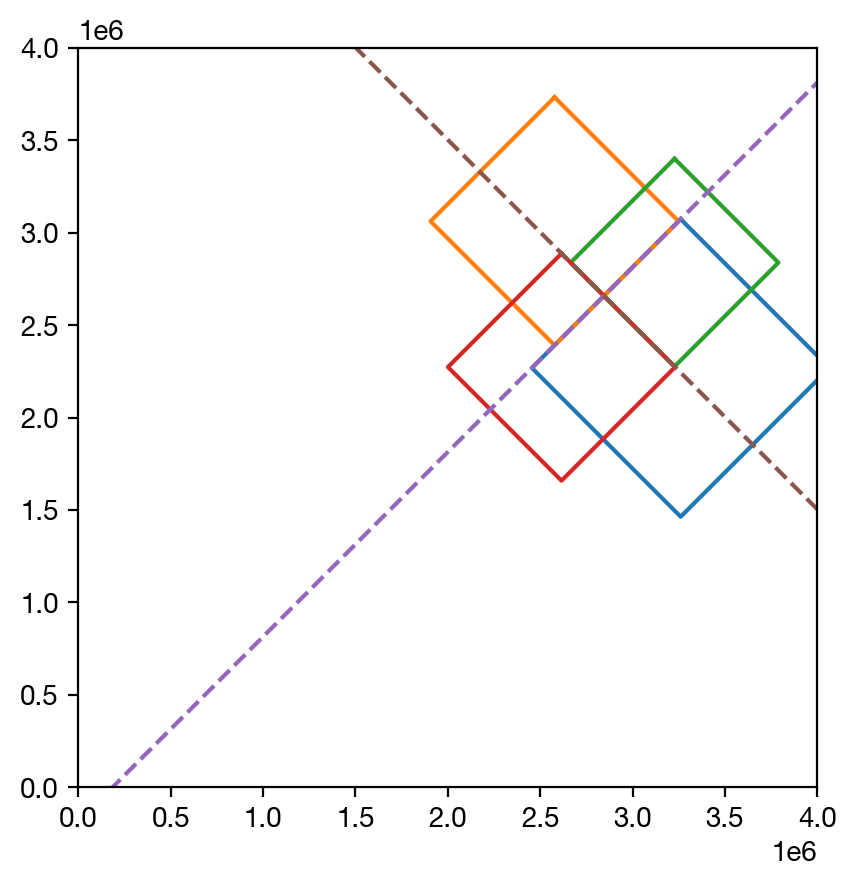

The beacon is at (2844848, 2658764)


11379394658764

In [5]:
filename = "../data/day15_data.txt"
solve_part_2(filename, lim=4000000, plotting=True)

In [ ]:
%timeit solve_part_2(filename, lim=4000000, plotting=False)